In [21]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

# System setup
A = np.array([[1.0, 1.0],
              [0.0, 1.0]])
B = np.array([[0.0],
              [1.0]])

nx = A.shape[0]
nu = B.shape[1]

# Horizon
N = 20

# Cost matrices
Q = np.diag([1.0, 1.0])
R = 0.1 * np.eye(nu)
Qf = Q

# Constraints
x_min = np.array([-10, -10])
x_max = np.array([10, 10])
u_min = np.array([-1.0])
u_max = np.array([1.0])

# Initial condition
x0 = np.array([5.0, 0.0])

# --- CasADi MPC setup ---
opti = ca.Opti()

X = opti.variable(nx, N+1)  # state trajectory
U = opti.variable(nu, N)    # control trajectory
x_init = opti.parameter(nx) # initial state

# Dynamics constraints
for k in range(N):
    x_next = A @ X[:, k] + B @ U[:, k]
    opti.subject_to(X[:, k+1] == x_next)

# Initial condition constraint
opti.subject_to(X[:, 0] == x_init)

# State and input constraints
for k in range(N):
    opti.subject_to(x_min <= X[:, k])
    opti.subject_to(X[:, k] <= x_max)
    opti.subject_to(u_min <= U[:, k])
    opti.subject_to(U[:, k] <= u_max)
opti.subject_to(x_min <= X[:, N])
opti.subject_to(X[:, N] <= x_max)

# Objective
cost = 0
for k in range(N):
    cost += ca.mtimes([X[:, k].T, Q, X[:, k]]) + ca.mtimes([U[:, k].T, R, U[:, k]])
cost += ca.mtimes([X[:, N].T, Qf, X[:, N]])
opti.minimize(cost)

With standard solver settings (in this case the solver is `ipopt`) we can solve the MPC problem and get the solution

In [22]:
# Solver
opts = {'print_time': False, 'ipopt.print_level': 0}
opti.solver('ipopt', opts)

# Simulate closed-loop
sim_steps = 30
x_cl = [x0]
u_cl = []

xk = x0
start = perf_counter()
for t in range(sim_steps):
    opti.set_value(x_init, xk)
    sol = opti.solve()
    u_opt = np.asarray([sol.value(U[:, 0])])
    xk = A @ xk + B @ u_opt

    x_cl.append(xk)
    u_cl.append(u_opt)

print(f"time spent with standard set_value: {perf_counter()- start}")

time spent with standard set_value: 0.1409693759997026


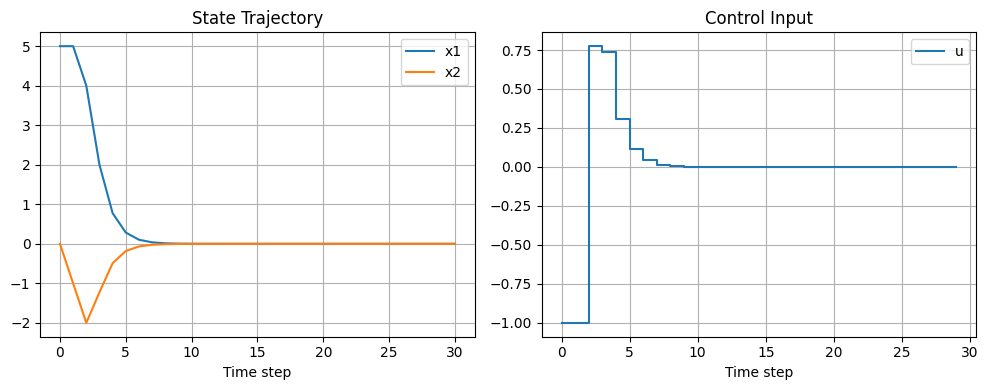

In [23]:
x_cl = np.array(x_cl)
u_cl = np.array(u_cl)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_cl[:, 0], label='x1')
plt.plot(x_cl[:, 1], label='x2')
plt.title('State Trajectory')
plt.xlabel('Time step')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.step(range(sim_steps), u_cl[:, 0], where='post', label='u')
plt.title('Control Input')
plt.xlabel('Time step')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Let's try now to see the time difference if we use the method `to_function` from `Opti`

In [24]:
sim_steps = 30
x_cl = [x0]
u_cl = []


# create function 
mpc = opti.to_function('MPCPlanner', [x_init], [U[:,0]], ['initial_state'], ['u_opt'])

xk = x0
start = perf_counter()
for t in range(sim_steps):
    u_opt = mpc(xk)
    xk = A @ xk + B @ u_opt

    x_cl.append(xk)
    u_cl.append(u_opt)
print(f"time spent with to_function set_value and cool options: {perf_counter()- start}")

time spent with to_function set_value and cool options: 0.12827572399692144


We can directly see that there has been quite reduction in the computational time. Something arounf 12% indeed. The main reson is due to some overhead that casadi experiences with calling the method `set_value` comapered to calling the function generated after `to_function`. At last note what happens if allow for restarting.



time spent with to_function set_value: 0.026254107004206162


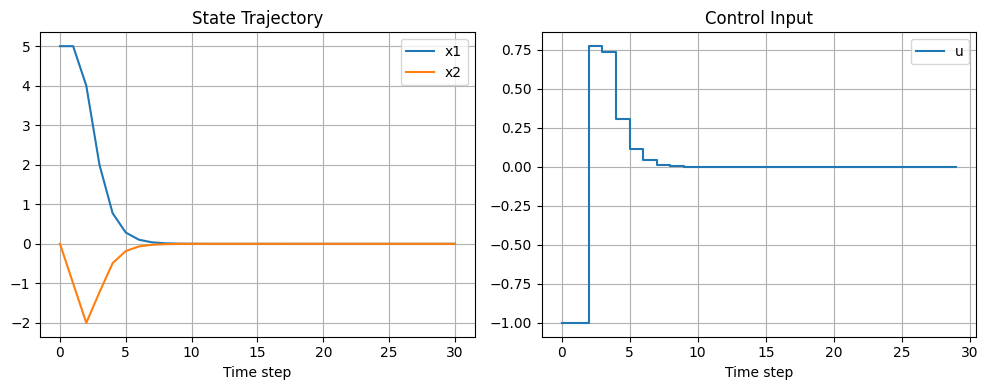

In [26]:
# --- CasADi MPC setup ---
opti1 = ca.Opti()

X = opti1.variable(nx, N+1)  # state trajectory
U = opti1.variable(nu, N)    # control trajectory
x_init = opti1.parameter(nx) # initial state

# Dynamics constraints
for k in range(N):
    x_next = A @ X[:, k] + B @ U[:, k]
    opti1.subject_to(X[:, k+1] == x_next)

# Initial condition constraint
opti1.subject_to(X[:, 0] == x_init)

# State and input constraints
for k in range(N):
    opti1.subject_to(x_min <= X[:, k])
    opti1.subject_to(X[:, k] <= x_max)
    opti1.subject_to(u_min <= U[:, k])
    opti1.subject_to(U[:, k] <= u_max)
opti1.subject_to(x_min <= X[:, N])
opti1.subject_to(X[:, N] <= x_max)

# Objective
cost = 0
for k in range(N):
    cost += ca.mtimes([X[:, k].T, Q, X[:, k]]) + ca.mtimes([U[:, k].T, R, U[:, k]])
cost += ca.mtimes([X[:, N].T, Qf, X[:, N]])
opti1.minimize(cost)

sim_steps = 30
x_cl = [x0]
u_cl = []

opts = {'ipopt.print_level': 0,
        'print_time': 0,
        'ipopt.tol': 1e-3, # let the precision get a biot worse
        'expand': 1,
        'error_on_fail':1,                              
        'ipopt.warm_start_init_point': 'yes', # automatic allow warm start
        'ipopt.warm_start_bound_push': 1e-8,
        'ipopt.warm_start_mult_bound_push': 1e-8,
        'ipopt.mu_init': 1e-5,
        'ipopt.bound_relax_factor': 1e-9}

opti1.solver('ipopt', opts)

# create function 
mpc = opti1.to_function('MPCPlanner', [x_init], [U[:,0]], ['initial_state'], ['u_opt'])

xk = x0
start = perf_counter()
for t in range(sim_steps):
    u_opt = mpc(xk)
    xk = (A @ xk + B @ u_opt).full().flatten()

    x_cl.append(xk)
    u_cl.append(u_opt)
print(f"time spent with to_function set_value: {perf_counter()- start}")

x_cl = np.array(x_cl)
u_cl = np.array(u_cl)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_cl[:, 0], label='x1')
plt.plot(x_cl[:, 1], label='x2')
plt.title('State Trajectory')
plt.xlabel('Time step')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.step(range(sim_steps), u_cl[:, 0], where='post', label='u')
plt.title('Control Input')
plt.xlabel('Time step')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Here we see that the solution time is now much lower. We just decreased the computational time of 80% just reducing a bit the precision of the solution and setting a warm-start option for the solver. 

Let me know if you experimented with other solver settings and hope this helps you with your projects